In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import torch

BASE_DIR = "/kaggle/input/image-matching-challenge-2025"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅", device)


✅ cpu


In [42]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "/kaggle/input/clip-b32/model"

model = CLIPModel.from_pretrained(model_path).to(device)
processor = CLIPProcessor.from_pretrained(model_path)

print("✅")

✅


In [43]:
from PIL import Image
import torch
from torchvision import transforms

def extract_clip_features(image_path, model, processor, device):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        features = model.get_image_features(**inputs)
        features = features / features.norm(p=2, dim=-1, keepdim=True)
    return features.cpu().numpy()


In [45]:
img1 = "/kaggle/input/image-matching-challenge-2025/test/stairs/stairs_split_1_1710453606287.png"
emb1 = extract_clip_features(img1, model, processor, device)
img2 = "/kaggle/input/image-matching-challenge-2025/test/stairs/stairs_split_1_1710453576271.png"
emb2 = extract_clip_features(img2, model, processor, device)
print("✅", emb1.shape)



✅ (1, 512)


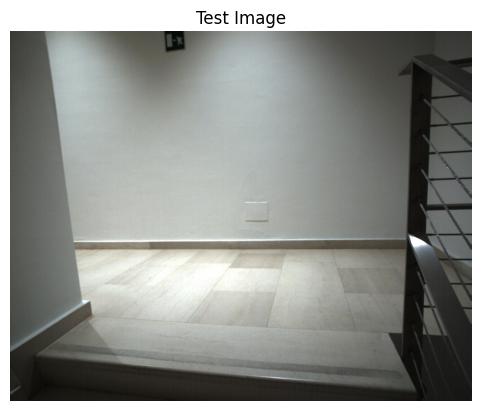

In [47]:
image = Image.open(img1)

plt.imshow(image)
plt.title("Test Image")
plt.axis("off")
plt.show()

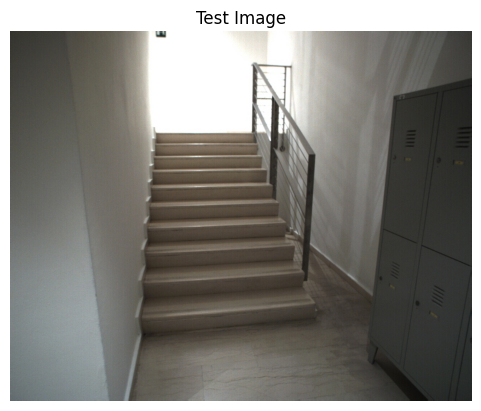

In [48]:
image = Image.open(img2)

plt.imshow(image)
plt.title("Test Image")
plt.axis("off")
plt.show()

In [ ]:
similarity = torch.nn.functional.cosine_similarity(
    torch.tensor(emb1),
    torch.tensor(emb2)
).item()

print(f"Cosine Similarity: {similarity:.4f}")

🎯 Cosine Similarity: 0.9238


In [56]:
SIMILARITY_THRESHOLD = 0.85
image_dir = "/kaggle/input/image-matching-challenge-2025/test"

image_paths = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(".png"):
            image_paths.append(os.path.join(root, file))

print(len(image_paths))


73


In [59]:
all_features = []
valid_image_paths = []

for img_path in image_paths:
    features = extract_clip_features(img_path, model, processor, device)
    if features is not None:
        all_features.append(features)
        valid_image_paths.append(img_path)
    else:
        print("!")

all_features_np = np.array(all_features)
all_features_np = np.squeeze(all_features_np, axis=1)

print(all_features_np.shape)

(73, 512)


In [60]:
similarity_matrix = np.dot(all_features_np, all_features_np.T)


In [62]:
print(np.diag(similarity_matrix)[:5])

[0.99999976 1.0000002  0.9999996  1.0000002  0.9999995 ]


In [63]:
similarity_matrix = np.clip(similarity_matrix, -1.0, 1.0)

In [64]:
print(np.diag(similarity_matrix)[:5])

[0.99999976 1.         0.9999996  1.         0.9999995 ]


In [67]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [69]:
adjacency_matrix = similarity_matrix > SIMILARITY_THRESHOLD

graph = csr_matrix(adjacency_matrix)
n_clusters, cluster_labels = connected_components(csgraph=graph, directed=False, return_labels=True)

print(f"Найдено кластеров: {n_clusters}")

Найдено кластеров: 6


In [70]:
clusters = {}
for i, img_path in enumerate(valid_image_paths):
    cluster_id = cluster_labels[i]
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(os.path.basename(img_path))

In [ ]:
print("\nРезультаты кластеризации:")
output_for_submission = []

for cluster_id, images_in_cluster in clusters.items():
    scene_name = f"cluster_{cluster_id}"
    print(f"  Кластер {scene_name}:")
    for img_name in images_in_cluster:
        print(f"    - {img_name}")
        dataset_name = os.path.basename(os.path.dirname(image_dir))
        output_for_submission.append({
            "dataset": dataset_name,
            "scene": scene_name,
            "image": img_name,
            "rotation_matrix": "nan;nan;nan;nan;nan;nan;nan;nan;nan",
            "translation_vector": "nan;nan;nan"
        })



Результаты кластеризации:
  Кластер cluster_0:
    - another_et_another_et004.png
    - another_et_another_et006.png
    - another_et_another_et009.png
    - another_et_another_et005.png
    - another_et_another_et008.png
    - another_et_another_et007.png
    - another_et_another_et003.png
    - another_et_another_et002.png
    - another_et_another_et010.png
    - another_et_another_et001.png
  Кластер cluster_1:
    - outliers_out_et003.png
  Кластер cluster_2:
    - et_et004.png
    - et_et002.png
    - et_et006.png
    - et_et008.png
    - et_et003.png
    - et_et007.png
    - et_et000.png
    - et_et001.png
    - et_et005.png
  Кластер cluster_3:
    - outliers_out_et001.png
  Кластер cluster_4:
    - outliers_out_et002.png
  Кластер cluster_5:
    - stairs_split_2_1710453740954.png
    - stairs_split_2_1710453759963.png
    - stairs_split_1_1710453990286.png
    - stairs_split_2_1710453786375.png
    - stairs_split_2_1710453756762.png
    - stairs_split_2_1710453728949.png
    -

In [74]:
df_submission = pd.DataFrame(output_for_submission)
display(df_submission.head())
df_submission.to_csv("/kaggle/working/submission.csv", index=False)



,dataset,scene,image,rotation_matrix,translation_vector
0,image-matching-challenge-2025,cluster_0,another_et_another_et004.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
1,image-matching-challenge-2025,cluster_0,another_et_another_et006.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
2,image-matching-challenge-2025,cluster_0,another_et_another_et009.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
3,image-matching-challenge-2025,cluster_0,another_et_another_et005.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
4,image-matching-challenge-2025,cluster_0,another_et_another_et008.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
